In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Parsers as P, Utilities as U
from mppi.Calculators import Tools
from mppi.Models import GaussianPulse as G
from mppi.Datasets import PostProcessing as PP
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.signal import argrelextrema

## Analysis of the transient absorption in bulk LiF

We study the transient absorption in bulk LiF. To this scope we use yambo_nl for the computation of the real time density matrix.

We use the SAVE folder and collisions matrix elements computed by D.Sangalli here _/work/sangalli/simulations/LiF/yambo/e80_kx6_pbe_sr/kx8_nb100/_.

## Analysis for the (100) field

Analysis is performed using a fixsym procedure to remove the symmetries broken by a linear 100 pulse. The associated
SAVE and collisions folders have been copied from the repository of D.Sangalli and are used here as starting point for the
present analysis.

In what follows we perform computations using updated parameters for the pump and probe pulses in order to match the experimental ones.

### Analysis of the (IR) (pump) pulse

### FIT of the experimental (IR) pump pulse

In [24]:
def A(t,a,b,c,d,e,h):
    return a*np.exp(-((t-b)/c)**2)*np.cos(d*t+h)

In [25]:
a = 1.00 #1.03
b = 0.07083
c = np.sqrt(20.7)
d = 2.382
e = -0.07674
h = 0 #np.pi/2

In [26]:
time = np.linspace(-10,10,num=1000)

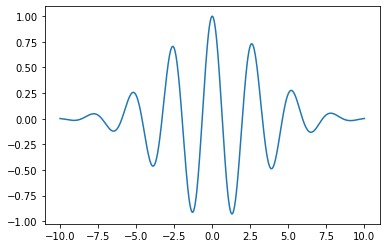

In [27]:
plt.plot(time,A(time,a,b,c,d,e,h))
#plt.xlim(-10,10)

d=omega=2pi/T=2pi*c/lambda

In [28]:
ll = 2*np.pi*U.Constants.Light_speed_nm_fsm1/d
eng = U.Constants.Planck_reduced_ev_fs*d
ll,eng

(790.7857125561936, 1.567860881574)

In [29]:
width = c/np.sqrt(2)
fwhm = 2*width*np.sqrt(2*np.log(2))
width,fwhm

(3.217141588429082, 7.575789500135511)

In [30]:
# FWHM of the intensity
fwhm/np.sqrt(2)

5.356892128387665

### Usage of the Gaussian Pulse of mppi

In [31]:
P_eng = 1.56 # eV
P_int = 2.6e9 # kWLm2
P_width = 3.22 # fs
P_start = -9.25  #-8.65 # fs

In [32]:
time = np.linspace(-10,10,num=1000)
pump = G.gaussianPulse(time,energy=P_eng,width=P_width,t_start=P_start)

time unit: fs - energy unit: eV
period of the oscillations 2.6510690366873857 fs
width of the pulse 3.22 fs
fwhm of the pulse 7.5825205449996576 fs


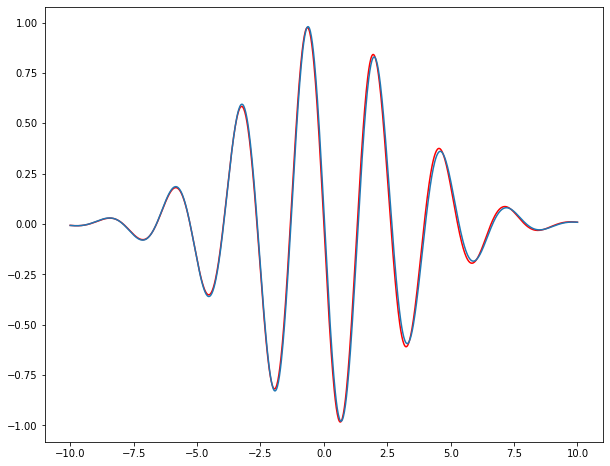

In [33]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(time,A(time,a,b,c,d,e,np.pi/2),c='red')
plt.plot(time,pump)

Note that in order to match we have set the h parameter to \pi/2, this is due to the fact that the gaussian pulse of mppi is build with a sine function.

### Usage of the field modelization of ypp_rt

In [108]:
# RunRules for ismhpc
# The product of ntasks_per_node*cpus_per_task is equal to 32. 
# Many mpi are needed for better performances
nodes = 1
ntasks_per_node = 16 #16
cpus_per_task = 2 #2
omp_num_threads = 2 #2
module = '/home/dalessandro/module_script/yambo_module'

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='slownodes', #'all12h',
                memory='125000',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,
                omp_num_threads=omp_num_threads,pre_processing=module)
code = C.YamboCalculator(rr,executable='ypp_rt',activate_BeeOND=True) #,reformat=False,clean_restart=False,skip=False,fatlog=True)
code.global_options()

Initialize a Yambo calculator with scheduler slurm


{'scheduler': 'slurm',
 'nodes': 1,
 'ntasks_per_node': 16,
 'cpus_per_task': 2,
 'omp_num_threads': 2,
 'gpus_per_node': None,
 'memory': '125000',
 'time': None,
 'partition': 'slownodes',
 'account': None,
 'qos': None,
 'map_by': None,
 'pe': 1,
 'rank_by': None,
 'pre_processing': '/home/dalessandro/module_script/yambo-nl_module',
 'executable': 'ypp_rt',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'activate_BeeOND': True,
 'verbose': True,
 'fatlog': False}

In [109]:
run_dir = 'NoTr_E100/'

In [227]:
inp = I.YamboInput(args='ypp_rt -rtplot f',folder=run_dir)
inp.set_array_variables(units='as',TimeStep= 10.)
inp.set_array_variables(units='fs',TimeRange=[0.,30.],Field1_FWHM=7.58,ChirpFac=0.)
inp.set_array_variables(units='eV',EnRngeRt=[0.,3.])
inp.set_array_variables(units='eV',Field1_Freq=[1.56,0.])
inp.set_array_variables(units='kWLm2',Field1_Int=1e3)
inp.set_array_variables(ETStpsRt= 301)
inp.set_scalar_variables(Field1_kind= "QSFIELD PHPI90")
inp

{'args': 'ypp_rt -rtplot f',
 'folder': 'NoTr_E100/',
 'filename': 'yambo.in',
 'arguments': ['RTtime', 'TDplots', 'RTfields'],
 'variables': {'TimeStep': [10.0, 'as'],
  'ETStpsRt': [301, ''],
  'ChirpFac': [0.0, 'fs'],
  'Field1_NFreqs': [1.0, ''],
  'Field1_Int': [1000.0, 'kWLm2'],
  'Field1_Width': [0.0, 'fs'],
  'Field1_Tstart': [0.0, 'fs'],
  'Field1_kind': 'QSFIELD PHPI90',
  'Field1_pol': 'none',
  'TimeRange': [[0.0, 30.0], 'fs'],
  'EnRngeRt': [[0.0, 3.0], 'eV'],
  'Field1_Freq': [[1.56, 0.0], 'eV'],
  'Field1_Dir': [[1.0, 0.0, 0.0], ''],
  'Field1_FWHM': [7.58, 'fs']}}

In [228]:
idd = 'field_test'
results = code.run(input=inp,run_dir=run_dir,name=idd,reformat=False,skip=False)

delete job_out script: NoTr_E100/job_field_test.out
delete folder: NoTr_E100/field_test
run command: mpirun -np 16 ypp_rt -F field_test.in -J field_test -C field_test
slurm submit:  cd NoTr_E100/ ; sbatch job_field_test.sh
computation field_test is running...
computation field_test ended

        There are no o-* files.
        Maybe you have performed a computation that does not create any output file or wait_end_run
        and/or the dry_run option are active.
        Otherwise a possible error has occured during the computation
        


In [260]:
# the first row has been erased
data = U.Utils.file_parser('NoTr_E100/field_test/YPP_EXTFIELD_1.time')

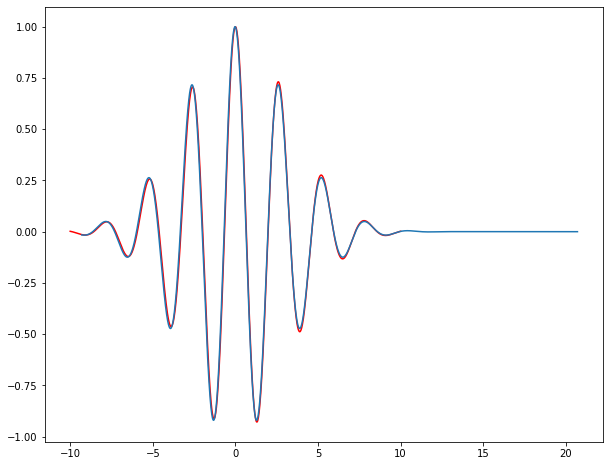

In [261]:
fig, ax = plt.subplots(figsize=(10, 8))
#plt.plot(time,pump,c='red')
plt.plot(time,A(time,a,b,c,d,e,h),c='red')
plt.plot(data[0]-9.3,data[1])

#### Probe (XUV pule)

In [34]:
p_eng = 35.0 # eV
p_int = 1e3 # kWLm2
p_width = 0.3*np.sqrt(2) # fs 
p_start = 0.0 # fs

In [35]:
time = np.linspace(-10,10,num=1000)

In [36]:
probe = G.gaussianPulse(time,energy=p_eng,fwhm=p_width)

time unit: fs - energy unit: eV
period of the oscillations 0.11816193420663777 fs
width of the pulse 0.18016836131796748 fs
fwhm of the pulse 0.4242640687119285 fs


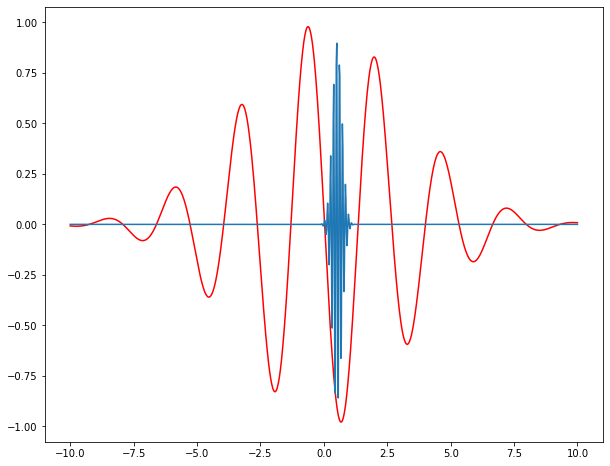

In [37]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(time,pump,c='red')
plt.plot(time,probe)

In yambo_nl the XUV pulse starts at around 3*w_IR-3*w_XUV

## RT analysis with yambo_nl

In [3]:
# RunRules for ismhpc
# The product of ntasks_per_node*cpus_per_task is equal to 32. 
# Many mpi are needed for better performances
nodes = 1
ntasks_per_node = 32 #16
cpus_per_task = 1 #2
omp_num_threads = 1 #2
module = '/home/dalessandro/module_script/yambo_module'

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='all12h', #'all12h',
                memory='125000',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,
                omp_num_threads=omp_num_threads,pre_processing=module)
code = C.YamboCalculator(rr,executable='yambo_nl',activate_BeeOND=True) #,reformat=False,clean_restart=False,skip=False,fatlog=True)
code.global_options()

Initialize a Yambo calculator with scheduler slurm


{'scheduler': 'slurm',
 'nodes': 1,
 'ntasks_per_node': 32,
 'cpus_per_task': 1,
 'omp_num_threads': 1,
 'gpus_per_node': None,
 'memory': '125000',
 'time': None,
 'partition': 'all12h',
 'account': None,
 'qos': None,
 'map_by': None,
 'pe': 1,
 'rank_by': None,
 'pre_processing': '/home/dalessandro/module_script/yambo_module',
 'executable': 'yambo_nl',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'activate_BeeOND': True,
 'verbose': True,
 'fatlog': False}

### RT non-linear analysis of the probe pulse

In [4]:
run_dir = 'NoTr_E100/'

In [5]:
p_fwhm = 0.3*np.sqrt(2) # fs build the fwhm of the vector potential starting from the fwhm of the intensity
np.round(p_fwhm/(2*np.sqrt(2*np.log(2))),3)

0.18

In [6]:
NLtime = 50 # fs
NLstep = 3 # as
Field1_kind= "QSFIELD PHPI90"
NLBands = [1,15]

p_eng = 35.0 # eV
p_int = 1e3 # kWLm2
p_fwhm = 0.42 # corresponds to 0.3*np.sqrt(2)
p_start = 0.0 # fs

inp = I.YamboInput(folder=run_dir,filename='../nl_input_template/template_p')
inp.set_array_variables(units='eV',Field1_Freq=[p_eng,0.])
inp.set_array_variables(units='fs',Field1_FWHM=p_fwhm,NLtime=NLtime)
inp.set_array_variables(units='as',NLstep=NLstep)
inp.set_array_variables(units='kWLm2',Field1_Int=p_int)
inp.set_array_variables(NLBands=NLBands)
inp.set_scalar_variables(Field1_kind=Field1_kind)
inp

{'args': '',
 'folder': 'NoTr_E100/',
 'filename': '../nl_input_template/template_p',
 'arguments': ['nloptics'],
 'variables': {'NLstep': [3, 'as'],
  'NLtime': [50, 'fs'],
  'NLDamping': [0.0, 'eV'],
  'Field1_Int': [1000.0, 'kWLm2'],
  'Field1_Width': [0.0, 'fs'],
  'Field1_Tstart': [0.0, 'fs'],
  'HARRLvcs': [339.0, 'RL'],
  'EXXRLvcs': [59.0, 'RL'],
  'CORRLvcs': [59.0, 'RL'],
  'NLverbosity': 'high',
  'NLintegrator': 'CRANKNIC',
  'NLCorrelation': 'SEX',
  'Field1_kind': 'QSFIELD PHPI90',
  'Field1_pol': 'linear',
  'NLBands': [[1, 15], ''],
  'GfnQP_E': [[6.0, 1.05, 1.05], ''],
  'IOtime': [[1.0, 5.0, 0.005], 'fs'],
  'Field1_Freq': [[35.0, 0.0], 'eV'],
  'Field1_Dir': [[1.0, 0.0, 0.0], ''],
  'Field1_Dir_circ': [[0.0, 0.0, 0.0], ''],
  'Field1_FWHM': [0.42, 'fs']}}

In [10]:
idd = 'td-nl-p-peng_%s-pfwhm_%s-nlbands_%s-%s-nlstep_%s-nltime_%s'%(p_eng,p_fwhm,NLBands[0],NLBands[1],NLstep,NLtime)
idd
jobname = [idd,'coll-par-cv_1-15B_X59RL-50B_noSM_H339RL_kpar']
results = code.run(run_dir=run_dir,input=inp,name=idd,jobname=jobname,reformat=False)

run command: mpirun -np 32 yambo_nl -F td-nl-p-peng_35.0-pfwhm_0.42-nlbands_1-15-nlstep_3-nltime_50.in -J "td-nl-p-peng_35.0-pfwhm_0.42-nlbands_1-15-nlstep_3-nltime_50,coll-par-cv_1-15B_X59RL-50B_noSM_H339RL_kpar" -C td-nl-p-peng_35.0-pfwhm_0.42-nlbands_1-15-nlstep_3-nltime_50
slurm submit:  cd NoTr_E100/ ; sbatch job_td-nl-p-peng_35.0-pfwhm_0.42-nlbands_1-15-nlstep_3-nltime_50.sh
computation td-nl-p-peng_35.0-pfwhm_0.42-nlbands_1-15-nlstep_3-nltime_50 is running...
computation td-nl-p-peng_35.0-pfwhm_0.42-nlbands_1-15-nlstep_3-nltime_50 ended
Run performed in 21m-29s


In [11]:
data = P.YamboParser(results,verbose=True)

Parse file NoTr_E100/td-nl-p-peng_35.0-pfwhm_0.42-nlbands_1-15-nlstep_3-nltime_50/o-td-nl-p-peng_35.0-pfwhm_0.42-nlbands_1-15-nlstep_3-nltime_50.current
Parse file NoTr_E100/td-nl-p-peng_35.0-pfwhm_0.42-nlbands_1-15-nlstep_3-nltime_50/o-td-nl-p-peng_35.0-pfwhm_0.42-nlbands_1-15-nlstep_3-nltime_50.polarization
Parse file NoTr_E100/td-nl-p-peng_35.0-pfwhm_0.42-nlbands_1-15-nlstep_3-nltime_50/o-td-nl-p-peng_35.0-pfwhm_0.42-nlbands_1-15-nlstep_3-nltime_50.carriers
Parse file NoTr_E100/td-nl-p-peng_35.0-pfwhm_0.42-nlbands_1-15-nlstep_3-nltime_50/o-td-nl-p-peng_35.0-pfwhm_0.42-nlbands_1-15-nlstep_3-nltime_50.external_field
Parse file NoTr_E100/td-nl-p-peng_35.0-pfwhm_0.42-nlbands_1-15-nlstep_3-nltime_50/o-td-nl-p-peng_35.0-pfwhm_0.42-nlbands_1-15-nlstep_3-nltime_50.NL_ext_pot_F1
Parse file NoTr_E100/td-nl-p-peng_35.0-pfwhm_0.42-nlbands_1-15-nlstep_3-nltime_50/o-td-nl-p-peng_35.0-pfwhm_0.42-nlbands_1-15-nlstep_3-nltime_50.NL_pol_F1
Parse file NoTr_E100/td-nl-p-peng_35.0-pfwhm_0.42-nlbands_1-1

In [12]:
time = data.data['carriers']['time']
dne = data.data['carriers']['dne']
px = data.data['polarization']['Pol_x']

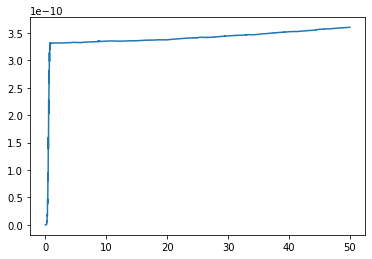

In [13]:
plt.plot(time,dne)

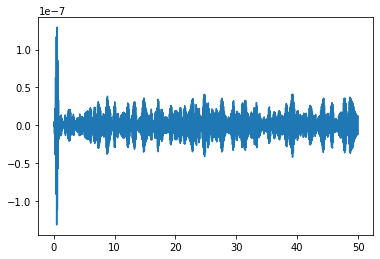

In [14]:
plt.plot(time,px)

### YPP analysis of the absorption spectrum

In [15]:
# RunRules for ismhpc
# The product of ntasks_per_node*cpus_per_task is equal to 32. 
# Many mpi are needed for better performances
nodes = 1
ntasks_per_node = 32 #16
cpus_per_task = 1 #2
omp_num_threads = 1 #2
module = '/home/dalessandro/module_script/yambo_module'

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='all12h', #'all12h',
                memory='125000',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,
                omp_num_threads=omp_num_threads,pre_processing=module)
code = C.YamboCalculator(rr,executable='ypp_rt',activate_BeeOND=True) #,reformat=False,clean_restart=False,skip=False,fatlog=True)
code.global_options()

Initialize a Yambo calculator with scheduler slurm


{'scheduler': 'slurm',
 'nodes': 1,
 'ntasks_per_node': 32,
 'cpus_per_task': 1,
 'omp_num_threads': 1,
 'gpus_per_node': None,
 'memory': '125000',
 'time': None,
 'partition': 'all12h',
 'account': None,
 'qos': None,
 'map_by': None,
 'pe': 1,
 'rank_by': None,
 'pre_processing': '/home/dalessandro/module_script/yambo_module',
 'executable': 'ypp_rt',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'activate_BeeOND': True,
 'verbose': True,
 'fatlog': False}

In [16]:
run_dir = 'NoTr_E100/'

In [17]:
EnRngeRt = [10.,50.] # eV
TimeRange = [0.,50.] # fs
DampFactor = 0.3 # eV
DampMode = 'LORENTZIAN'

inp = I.YamboInput(args='ypp_rt -rtplot X',folder=run_dir)
inp.set_array_variables(units='eV',EnRngeRt=EnRngeRt,DampFactor=DampFactor)
inp.set_array_variables(units='fs',TimeRange=TimeRange)
inp.set_scalar_variables(DampMode=DampMode)
inp

{'args': 'ypp_rt -rtplot X',
 'folder': 'NoTr_E100/',
 'filename': 'yambo.in',
 'arguments': ['RT_X', 'RTtime', 'TDplots'],
 'variables': {'Xorder': [1.0, ''],
  'ETStpsRt': [200.0, ''],
  'DampFactor': [0.3, 'eV'],
  'DampMode': 'LORENTZIAN',
  'EnRngeRt': [[10.0, 50.0], 'eV'],
  'TimeRange': [[0.0, 50.0], 'fs']}}

In [18]:
idd = 'ypp-p-abs-damp_%s-enrnge_%s_%s-timernge_%s-%s'%(DampFactor,EnRngeRt[0],EnRngeRt[1],TimeRange[0],TimeRange[1])
idd
jobname = [idd,'td-nl-p-peng_35.0-pfwhm_0.42-nlbands_1-15-nlstep_3-nltime_50']
results = code.run(run_dir=run_dir,input=inp,name=idd,jobname=jobname,reformat=False,clean_restart=False)

run performed starting from existing results
run command: mpirun -np 32 ypp_rt -F ypp-p-abs-damp_0.3-enrnge_10.0_50.0-timernge_0.0-50.0.in -J "ypp-p-abs-damp_0.3-enrnge_10.0_50.0-timernge_0.0-50.0,td-nl-p-peng_35.0-pfwhm_0.42-nlbands_1-15-nlstep_3-nltime_50" -C ypp-p-abs-damp_0.3-enrnge_10.0_50.0-timernge_0.0-50.0
slurm submit:  cd NoTr_E100/ ; sbatch job_ypp-p-abs-damp_0.3-enrnge_10.0_50.0-timernge_0.0-50.0.sh
computation ypp-p-abs-damp_0.3-enrnge_10.0_50.0-timernge_0.0-50.0 is running...
computation ypp-p-abs-damp_0.3-enrnge_10.0_50.0-timernge_0.0-50.0 ended
Run performed in 15s


In [19]:
data=P.YamboOutputParser.from_file('NoTr_E100/ypp-p-abs-damp_0.3-enrnge_10.0_50.0-timernge_0.0-50.0/o-ypp-p-abs-damp_0.3-enrnge_10.0_50.0-timernge_0.0-50.0.YPP-eps_along_E')

Parse file NoTr_E100/ypp-p-abs-damp_0.3-enrnge_10.0_50.0-timernge_0.0-50.0/o-ypp-p-abs-damp_0.3-enrnge_10.0_50.0-timernge_0.0-50.0.YPP-eps_along_E


In [20]:
eng_p = data['YPP-eps_along_E']['col1']
eps_p = data['YPP-eps_along_E']['col2']

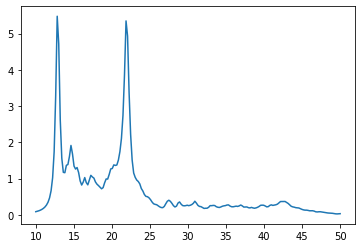

In [21]:
plt.plot(eng_p,eps_p)

### RT non-linear analysis of the pump pulse

In [100]:
# RunRules for ismhpc
# The product of ntasks_per_node*cpus_per_task is equal to 32. 
# Many mpi are needed for better performances
nodes = 1
ntasks_per_node = 32 #16
cpus_per_task = 1 #2
omp_num_threads = 1 #2
module = '/home/dalessandro/module_script/yambo_module'

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='all12h', #'all12h',
                memory='125000',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,
                omp_num_threads=omp_num_threads,pre_processing=module)
code = C.YamboCalculator(rr,executable='yambo_nl',activate_BeeOND=True) #,reformat=False,clean_restart=False,skip=False,fatlog=True)
code.global_options()

Initialize a Yambo calculator with scheduler slurm


{'scheduler': 'slurm',
 'nodes': 1,
 'ntasks_per_node': 32,
 'cpus_per_task': 1,
 'omp_num_threads': 1,
 'gpus_per_node': None,
 'memory': '125000',
 'time': None,
 'partition': 'all12h',
 'account': None,
 'qos': None,
 'map_by': None,
 'pe': 1,
 'rank_by': None,
 'pre_processing': '/home/dalessandro/module_script/yambo_module',
 'executable': 'yambo_nl',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'activate_BeeOND': True,
 'verbose': True,
 'fatlog': False}

In [91]:
run_dir = 'NoTr_E100/'

In [101]:
NLtime = 50 # fs
NLstep = 3 # as
Field1_kind=  "QSFIELD 5SIGMA PHPI90" #"QSFIELD PHPI90"
NLBands = [1,15]

P_eng = 1.56 # eV
P_int = 2.6e9 # 2*2.6e9 # kWLm2
P_fwhm = 7.58 # corresponds to 0.3*np.sqrt(2)
P_start = 0.0 # fs
NLDamping = 0.0 # eV

inp = I.YamboInput(folder=run_dir,filename='../nl_input_template/template_p')
inp.set_array_variables(units='eV',Field1_Freq=[P_eng,0.],NLDamping=NLDamping)
inp.set_array_variables(units='fs',Field1_FWHM=P_fwhm,NLtime=NLtime,Field1_Tstart=P_start)
inp.set_array_variables(units='as',NLstep=NLstep)
inp.set_array_variables(units='kWLm2',Field1_Int=P_int)
inp.set_array_variables(NLBands=NLBands)
inp.set_scalar_variables(Field1_kind=Field1_kind)
inp

{'args': '',
 'folder': 'NoTr_E100/',
 'filename': '../nl_input_template/template_p',
 'arguments': ['nloptics'],
 'variables': {'NLstep': [3, 'as'],
  'NLtime': [50, 'fs'],
  'NLDamping': [0.0, 'eV'],
  'Field1_Int': [2600000000.0, 'kWLm2'],
  'Field1_Width': [0.0, 'fs'],
  'Field1_Tstart': [0.0, 'fs'],
  'HARRLvcs': [339.0, 'RL'],
  'EXXRLvcs': [59.0, 'RL'],
  'CORRLvcs': [59.0, 'RL'],
  'NLverbosity': 'high',
  'NLintegrator': 'CRANKNIC',
  'NLCorrelation': 'SEX',
  'Field1_kind': 'QSFIELD 5SIGMA PHPI90',
  'Field1_pol': 'linear',
  'NLBands': [[1, 15], ''],
  'GfnQP_E': [[6.0, 1.05, 1.05], ''],
  'IOtime': [[1.0, 5.0, 0.005], 'fs'],
  'Field1_Freq': [[1.56, 0.0], 'eV'],
  'Field1_Dir': [[1.0, 0.0, 0.0], ''],
  'Field1_Dir_circ': [[0.0, 0.0, 0.0], ''],
  'Field1_FWHM': [7.58, 'fs']}}

In [102]:
#idd = 'td-nl-P-Peng_%s-Pfwhm_%s-nlbands_%s-%s-nlstep_%s-nltime_%s-double_Pint'%(P_eng,P_fwhm,NLBands[0],NLBands[1],NLstep,NLtime)
idd = 'td-nl-P-5SIGMA'
#idd
jobname = [idd,'coll-par-cv_1-15B_X59RL-50B_noSM_H339RL_kpar']
results = code.run(run_dir=run_dir,input=inp,name=idd,jobname=jobname,reformat=False,skip=True)

Skip the run of td-nl-P-5SIGMA


In [103]:
data = P.YamboParser(results,verbose=True)

Parse file NoTr_E100/td-nl-P-5SIGMA/o-td-nl-P-5SIGMA.current
Parse file NoTr_E100/td-nl-P-5SIGMA/o-td-nl-P-5SIGMA.polarization
Parse file NoTr_E100/td-nl-P-5SIGMA/o-td-nl-P-5SIGMA.carriers
Parse file NoTr_E100/td-nl-P-5SIGMA/o-td-nl-P-5SIGMA.external_field
Parse file NoTr_E100/td-nl-P-5SIGMA/o-td-nl-P-5SIGMA.NL_ext_pot_F1
Parse file NoTr_E100/td-nl-P-5SIGMA/o-td-nl-P-5SIGMA.NL_pol_F1
Parse file NoTr_E100/td-nl-P-5SIGMA/o-td-nl-P-5SIGMA.NL_Etot_F1
Parse file : NoTr_E100/SAVE/ns.db1
Parse file : NoTr_E100/td-nl-P-5SIGMA/ndb.dipoles
Spin dipoles not found in the ndb.dipoles


In [104]:
time = data.data['carriers']['time']
dne = data.data['carriers']['dne']
px = data.data['polarization']['Pol_x']
ex = data.data['external_field']['Ex_Re']

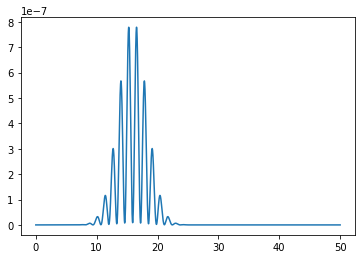

In [105]:
plt.plot(time,dne)

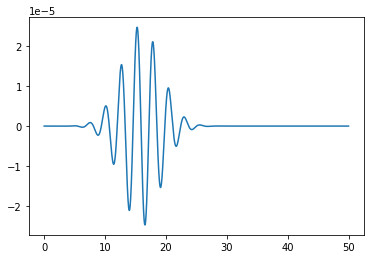

In [106]:
plt.plot(time,px)

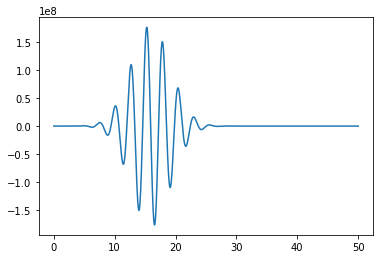

In [107]:
plt.plot(time,ex)

### RT non-linear analysis of the pump and probe dynamics

In [3]:
# RunRules for ismhpc
# The product of ntasks_per_node*cpus_per_task is equal to 32. 
# Many mpi are needed for better performances
nodes = 1
ntasks_per_node = 32 #16
cpus_per_task = 1 #2
omp_num_threads = 1 #2
module = '/home/dalessandro/module_script/yambo_module'

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='all12h', #'all12h',
                memory='125000',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,
                omp_num_threads=omp_num_threads,pre_processing=module)
code = C.YamboCalculator(rr,executable='yambo_nl',activate_BeeOND=True) #,reformat=False,clean_restart=False,skip=False,fatlog=True)
code.global_options()

Initialize a Yambo calculator with scheduler slurm


{'scheduler': 'slurm',
 'nodes': 1,
 'ntasks_per_node': 32,
 'cpus_per_task': 1,
 'omp_num_threads': 1,
 'gpus_per_node': None,
 'memory': '125000',
 'time': None,
 'partition': 'all12h',
 'account': None,
 'qos': None,
 'map_by': None,
 'pe': 1,
 'rank_by': None,
 'pre_processing': '/home/dalessandro/module_script/yambo_module',
 'executable': 'yambo_nl',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'activate_BeeOND': True,
 'verbose': True,
 'fatlog': False}

In [1]:
run_dir = 'NoTr_E100/'

In [5]:
# compute the p_start for the 3SIGMA or 5SIGMA cases
P_width = 3.22 
p_width = 0.18 # fs
np.round(5*P_width-3*p_width,2)

15.56

In [6]:
NLtime = 50 # fs
NLstep = 3 # as
Field1_kind= "QSFIELD" # "QSFIELD PHPI90" # 
Field2_kind= "QSFIELD 5SIGMA PHPI90"
NLBands = [1,15]

#Field1 parameters
p_eng = 35.0 # eV
p_int = 1e3 # kWLm2
p_fwhm = 0.42 # corresponds to 0.3*np.sqrt(2)
p_width = 0.18 # fs
p_start = 15.6 # 9.12 #np.round(3*P_width-3*p_width,2) # fs

#Field2 parameters
P_eng = 1.56 # eV
P_int = 2.6e9 # 2*2.6e9 # kWLm2
P_fwhm = 7.58 # corresponds to 0.3*np.sqrt(2)
P_width = 3.22 
P_start = 0.0 # fs

inp = I.YamboInput(folder=run_dir,filename='../nl_input_template/template_Pp')
inp.set_array_variables(units='eV',Field2_Freq=[P_eng,0.],Field1_Freq=[p_eng,0.])
inp.set_array_variables(units='fs',Field2_FWHM=P_fwhm,Field1_FWHM=p_fwhm,NLtime=NLtime,Field1_Tstart=p_start)
inp.set_array_variables(units='as',NLstep=NLstep)
inp.set_array_variables(units='kWLm2',Field2_Int=P_int,Field1_Int=p_int)
inp.set_array_variables(NLBands=NLBands)
inp.set_scalar_variables(Field1_kind=Field1_kind,Field2_kind=Field2_kind)
inp

{'args': '',
 'folder': 'Nl_chi',
 'filename': '../nl_input_template/template_Pp',
 'arguments': ['nloptics'],
 'variables': {'NLstep': [3, 'as'],
  'NLtime': [50, 'fs'],
  'NLDamping': [0.0, 'eV'],
  'Field1_Int': [1000.0, 'kWLm2'],
  'Field1_Tstart': [15.6, 'fs'],
  'Field2_Int': [2600000000.0, 'kWLm2'],
  'Field2_Tstart': [0.0, 'fs'],
  'HARRLvcs': [339.0, 'RL'],
  'EXXRLvcs': [59.0, 'RL'],
  'CORRLvcs': [59.0, 'RL'],
  'NLverbosity': 'high',
  'NLintegrator': 'CRANKNIC',
  'NLCorrelation': 'SEX',
  'Field1_kind': 'QSFIELD',
  'Field1_pol': 'linear',
  'Field2_kind': 'QSFIELD 5SIGMA PHPI90',
  'Field2_pol': 'linear',
  'NLBands': [[1, 15], ''],
  'GfnQP_E': [[6.0, 1.05, 1.05], ''],
  'IOtime': [[1.0, 5.0, 0.005], 'fs'],
  'Field1_Freq': [[35.0, 0.0], 'eV'],
  'Field1_Dir': [[1.0, 0.0, 0.0], ''],
  'Field1_Dir_circ': [[0.0, 0.0, 0.0], ''],
  'Field2_Freq': [[1.56, 0.0], 'eV'],
  'Field2_Dir': [[1.0, 0.0, 0.0], ''],
  'Field2_Dir_circ': [[0.0, 0.0, 0.0], ''],
  'Field2_FWHM': [7.58, '

In [7]:
#idd = 'td-nl-Pp-5SIGMA'
idd = 'td-nl-Pp-5SIGMA-ph0'

#idd = 'td-nl-Pp-Peng_%s-peng_%s-Pfwhm_%s-pfwhm_%s-delay_%s-nlbands_%s-%s-nlstep_%s-nltime_%s'%(P_eng,p_eng,P_fwhm,p_fwhm,p_start,NLBands[0],NLBands[1],NLstep,NLtime)
#idd = 'td-nl-Pp-Peng_%s-peng_%s-Pfwhm_%s-pfwhm_%s-delay_%s-nlbands_%s-%s-nlstep_%s-nltime_%s-dPint'%(P_eng,p_eng,P_fwhm,p_fwhm,p_start,NLBands[0],NLBands[1],NLstep,NLtime)
#idd = 'td-nl-Pp-Peng_%s-peng_%s-Pfwhm_%s-pfwhm_%s-delay_%s-nlbands_%s-%s-nlstep_%s-nltime_%s-p_ph0'%(P_eng,p_eng,P_fwhm,p_fwhm,p_start,NLBands[0],NLBands[1],NLstep,NLtime)
#idd

jobname = [idd,'coll-par-cv_1-15B_X59RL-50B_noSM_H339RL_kpar']
results = code.run(run_dir=run_dir,input=inp,name=idd,jobname=jobname,reformat=False)

run command: mpirun -np 32 yambo_nl -F td-nl-Pp-5SIGMA-ph0.in -J "td-nl-Pp-5SIGMA-ph0,coll-par-cv_1-15B_X59RL-50B_noSM_H339RL_kpar" -C td-nl-Pp-5SIGMA-ph0
slurm submit:  cd Nl_chi ; sbatch job_td-nl-Pp-5SIGMA-ph0.sh
computation td-nl-Pp-5SIGMA-ph0 is running...
computation td-nl-Pp-5SIGMA-ph0 ended


FileNotFoundError: [Errno 2] No such file or directory: 'Nl_chi/td-nl-Pp-5SIGMA-ph0'

In [129]:
data = P.YamboParser(results,verbose=True)

Parse file NoTr_E100/td-nl-Pp-5SIGMA-ph0/o-td-nl-Pp-5SIGMA-ph0.current
Parse file NoTr_E100/td-nl-Pp-5SIGMA-ph0/o-td-nl-Pp-5SIGMA-ph0.polarization
Parse file NoTr_E100/td-nl-Pp-5SIGMA-ph0/o-td-nl-Pp-5SIGMA-ph0.carriers
Parse file NoTr_E100/td-nl-Pp-5SIGMA-ph0/o-td-nl-Pp-5SIGMA-ph0.external_field
Parse file NoTr_E100/td-nl-Pp-5SIGMA-ph0/o-td-nl-Pp-5SIGMA-ph0.NL_ext_pot_F1
Parse file NoTr_E100/td-nl-Pp-5SIGMA-ph0/o-td-nl-Pp-5SIGMA-ph0.NL_pol_F1
Parse file NoTr_E100/td-nl-Pp-5SIGMA-ph0/o-td-nl-Pp-5SIGMA-ph0.NL_Etot_F1
Parse file : NoTr_E100/SAVE/ns.db1
Parse file : NoTr_E100/td-nl-Pp-5SIGMA-ph0/ndb.dipoles
Spin dipoles not found in the ndb.dipoles


In [130]:
time = data.data['carriers']['time']
dne = data.data['carriers']['dne']
px = data.data['polarization']['Pol_x']
ex = data.data['external_field']['Ex_Re']

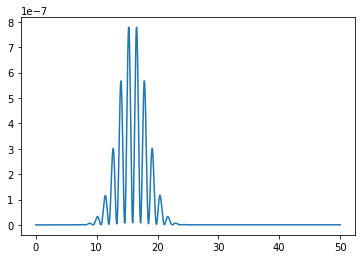

In [131]:
plt.plot(time,dne)

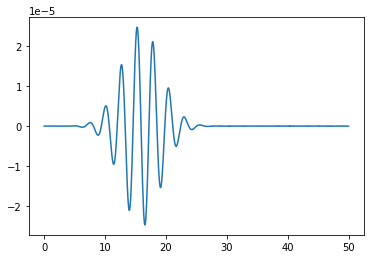

In [132]:
plt.plot(time,px)

In [133]:
ex = data.data['external_field']['Ex_Re']

(0.0, 60.0)

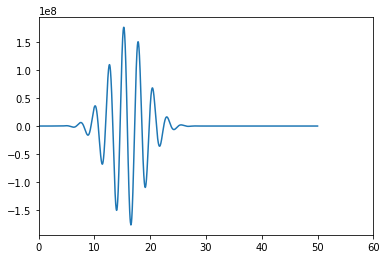

In [134]:
plt.plot(time,ex)
plt.xlim(0,60)

### YPP analysis of the absorption spectrum

In [27]:
# RunRules for ismhpc
# The product of ntasks_per_node*cpus_per_task is equal to 32. 
# Many mpi are needed for better performances
nodes = 1
ntasks_per_node = 1 #16
cpus_per_task = 1 #2
omp_num_threads = 1 #2
module = '/home/dalessandro/module_script/yambo_module'

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='all12h', #'all12h',
                memory='125000',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,
                omp_num_threads=omp_num_threads,pre_processing=module)
code = C.YamboCalculator(rr,executable='ypp_rt',activate_BeeOND=True) #,reformat=False,clean_restart=False,skip=False,fatlog=True)
code.global_options()

Initialize a Yambo calculator with scheduler slurm


{'scheduler': 'slurm',
 'nodes': 1,
 'ntasks_per_node': 1,
 'cpus_per_task': 1,
 'omp_num_threads': 1,
 'gpus_per_node': None,
 'memory': '125000',
 'time': None,
 'partition': 'all12h',
 'account': None,
 'qos': None,
 'map_by': None,
 'pe': 1,
 'rank_by': None,
 'pre_processing': '/home/dalessandro/module_script/yambo_module',
 'executable': 'ypp_rt',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'activate_BeeOND': True,
 'verbose': True,
 'fatlog': False}

In [28]:
run_dir = 'NoTr_E100/'

In [29]:
EnRngeRt = [10.,50.] # eV
TimeRange = [0.,50.] # fs # [0.,50.] # fs
DampFactor = 0.3 # eV
DampMode = 'LORENTZIAN'

inp = I.YamboInput(args='ypp_rt -rtplot X',folder=run_dir)
inp.set_array_variables(units='eV',EnRngeRt=EnRngeRt,DampFactor=DampFactor)
inp.set_array_variables(units='fs',TimeRange=TimeRange)
inp.set_scalar_variables(DampMode=DampMode,XKind='rhorho')
inp.set_scalar_variables(PumpKey='td-nl-P-Peng_1.56-Pfwhm_7.58-nlbands_1-15-nlstep_3-nltime_50')
#inp.set_scalar_variables(PumpKey='td-nl-P-Peng_1.56-Pfwhm_7.58-nlbands_1-15-nlstep_3-nltime_50-double_Pint')
inp

{'args': 'ypp_rt -rtplot X',
 'folder': 'NoTr_E100/',
 'filename': 'yambo.in',
 'arguments': ['RT_X', 'RTtime', 'TDplots'],
 'variables': {'Xorder': [1.0, ''],
  'ETStpsRt': [200.0, ''],
  'DampFactor': [0.3, 'eV'],
  'DampMode': 'LORENTZIAN',
  'EnRngeRt': [[10.0, 50.0], 'eV'],
  'TimeRange': [[0.0, 50.0], 'fs'],
  'XKind': 'rhorho',
  'PumpKey': 'td-nl-P-Peng_1.56-Pfwhm_7.58-nlbands_1-15-nlstep_3-nltime_50'}}

In [31]:
#idd = 'ypp-trs-abs-damp_%s-enrnge_%s_%s-timernge_%s-%s'%(DampFactor,EnRngeRt[0],EnRngeRt[1],TimeRange[0],TimeRange[1])
#idd = 'ypp-trs-abs-damp_%s-enrnge_%s_%s-timernge_%s-%s_ph0'%(DampFactor,EnRngeRt[0],EnRngeRt[1],TimeRange[0],TimeRange[1])
#idd = 'ypp-trs-abs-damp_%s-enrnge_%s_%s-timernge_%s-%s-double_Pint'%(DampFactor,EnRngeRt[0],EnRngeRt[1],TimeRange[0],TimeRange[1])
#idd = 'ypp-trs-abs-damp_%s-enrnge_%s_%s-timernge_%s-%s-delay_7'%(DampFactor,EnRngeRt[0],EnRngeRt[1],TimeRange[0],TimeRange[1])
idd = 'ypp-trs-abs-damp_%s-enrnge_%s_%s-timernge_%s-%s-delay_7_ph0'%(DampFactor,EnRngeRt[0],EnRngeRt[1],TimeRange[0],TimeRange[1])

#jobname = [idd,'td-nl-Pp-Peng_1.56-peng_35.0-Pfwhm_7.58-pfwhm_0.42-delay_9.12-nlbands_1-15-nlstep_3-nltime_50']
#jobname = [idd,'td-nl-Pp-Peng_1.56-peng_35.0-Pfwhm_7.58-pfwhm_0.42-delay_9.12-nlbands_1-15-nlstep_3-nltime_50_ph0']
#jobname = [idd,'td-nl-Pp-Peng_1.56-peng_35.0-Pfwhm_7.58-pfwhm_0.42-delay_9.12-nlbands_1-15-nlstep_3-nltime_50-dPint']
#jobname = [idd,'td-nl-Pp-Peng_1.56-peng_35.0-Pfwhm_7.58-pfwhm_0.42-delay_7.0-nlbands_1-15-nlstep_3-nltime_50']
jobname = [idd,'td-nl-Pp-Peng_1.56-peng_35.0-Pfwhm_7.58-pfwhm_0.42-delay_7.0-nlbands_1-15-nlstep_3-nltime_50-p_ph0']

results = code.run(run_dir=run_dir,input=inp,name=idd,jobname=jobname,reformat=False,skip=False)

delete job_out script: NoTr_E100/job_ypp-trs-abs-damp_0.3-enrnge_10.0_50.0-timernge_0.0-50.0-delay_7_ph0.out
delete folder: NoTr_E100/ypp-trs-abs-damp_0.3-enrnge_10.0_50.0-timernge_0.0-50.0-delay_7_ph0
run command: mpirun -np 1 ypp_rt -F ypp-trs-abs-damp_0.3-enrnge_10.0_50.0-timernge_0.0-50.0-delay_7_ph0.in -J "ypp-trs-abs-damp_0.3-enrnge_10.0_50.0-timernge_0.0-50.0-delay_7_ph0,td-nl-Pp-Peng_1.56-peng_35.0-Pfwhm_7.58-pfwhm_0.42-delay_7.0-nlbands_1-15-nlstep_3-nltime_50-p_ph0" -C ypp-trs-abs-damp_0.3-enrnge_10.0_50.0-timernge_0.0-50.0-delay_7_ph0
slurm submit:  cd NoTr_E100/ ; sbatch job_ypp-trs-abs-damp_0.3-enrnge_10.0_50.0-timernge_0.0-50.0-delay_7_ph0.sh
computation ypp-trs-abs-damp_0.3-enrnge_10.0_50.0-timernge_0.0-50.0-delay_7_ph0 is running...
computation ypp-trs-abs-damp_0.3-enrnge_10.0_50.0-timernge_0.0-50.0-delay_7_ph0 ended
Run performed in 04s


### Transient spectrum and reflectivity

In [60]:
data=P.YamboOutputParser.from_file('NoTr_E100/ypp-trs-abs-damp_0.3-enrnge_10.0_50.0-timernge_0.0-50.0/o-ypp-trs-abs-damp_0.3-enrnge_10.0_50.0-timernge_0.0-50.0.YPP-eps_along_E')
data_ph0=P.YamboOutputParser.from_file('NoTr_E100/ypp-trs-ph0/o-ypp-trs-ph0.YPP-eps_along_E')
data_probe=P.YamboOutputParser.from_file('NoTr_E100/ypp-p-abs-damp_0.3-enrnge_10.0_50.0-timernge_0.0-50.0/o-ypp-p-abs-damp_0.3-enrnge_10.0_50.0-timernge_0.0-50.0.YPP-eps_along_E')
data_dPint = P.YamboOutputParser.from_file('NoTr_E100/ypp-trs-abs-damp_0.3-enrnge_10.0_50.0-timernge_0.0-50.0-double_Pint/o-ypp-trs-abs-damp_0.3-enrnge_10.0_50.0-timernge_0.0-50.0-double_Pint.YPP-eps_along_E')

Parse file NoTr_E100/ypp-trs-abs-damp_0.3-enrnge_10.0_50.0-timernge_0.0-50.0/o-ypp-trs-abs-damp_0.3-enrnge_10.0_50.0-timernge_0.0-50.0.YPP-eps_along_E
Parse file NoTr_E100/ypp-trs-ph0/o-ypp-trs-ph0.YPP-eps_along_E
Parse file NoTr_E100/ypp-p-abs-damp_0.3-enrnge_10.0_50.0-timernge_0.0-50.0/o-ypp-p-abs-damp_0.3-enrnge_10.0_50.0-timernge_0.0-50.0.YPP-eps_along_E
Parse file NoTr_E100/ypp-trs-abs-damp_0.3-enrnge_10.0_50.0-timernge_0.0-50.0-double_Pint/o-ypp-trs-abs-damp_0.3-enrnge_10.0_50.0-timernge_0.0-50.0-double_Pint.YPP-eps_along_E


In [61]:
eng = data['YPP-eps_along_E']['col1']
eps2_trs = data['YPP-eps_along_E']['col2']
eps1_trs = data['YPP-eps_along_E']['col5']
eps2_trs_ph0 = data_ph0['YPP-eps_along_E']['col2']
eps1_trs_ph0 = data_ph0['YPP-eps_along_E']['col5']
eps2_trs_dPint = data_dPint['YPP-eps_along_E']['col2']
eps1_trs_dPint = data_dPint['YPP-eps_along_E']['col5']
eps2_eq = data_probe['YPP-eps_along_E']['col2']
eps1_eq = data_probe['YPP-eps_along_E']['col5']

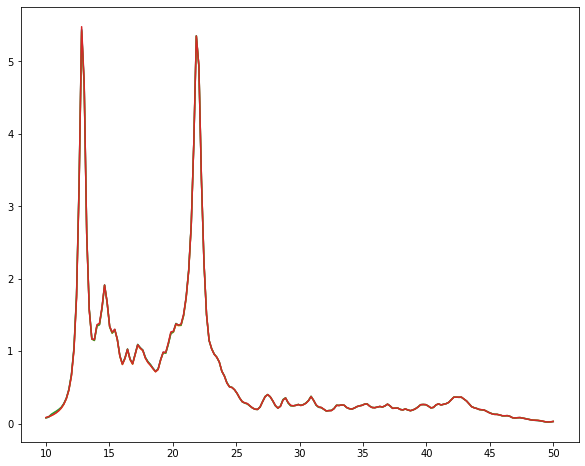

In [62]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(eng,eps2_trs)
plt.plot(eng,eps2_trs_ph0)
plt.plot(eng,eps2_trs_dPint)
plt.plot(eng,eps2_eq)

We compute the shift of the absorption spectrum

In [63]:
deps2 = (eps2_trs-eps2_eq)/eps2_eq
deps2_dPint = (eps2_trs_dPint-eps2_eq)/eps2_eq
deps2_ph0 = (eps2_trs_ph0-eps2_eq)/eps2_eq

(-0.04, 0.06)

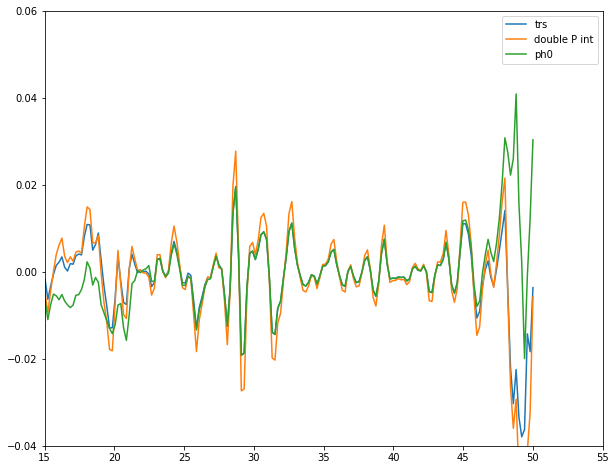

In [64]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(eng,deps2,label='trs')
plt.plot(eng,deps2_dPint,label='double P int')
plt.plot(eng,deps2_ph0,label='ph0')
plt.legend()
plt.xlim(15,55)
plt.ylim(-0.04,0.06)

We build the refractive index

In [8]:
n_trs = np.sqrt(eps1_trs+1j*eps2_trs)
n_trs_ph0 = np.sqrt(eps1_trs_ph0+1j*eps2_trs_ph0)
n_eq = np.sqrt(eps1_eq+1j*eps2_eq)

In [9]:
R_trs = np.abs((n_trs-1)/(n_trs+1))**2
R_trs_ph0 = np.abs((n_trs_ph0-1)/(n_trs_ph0+1))**2
R_eq = np.abs((n_eq-1)/(n_eq+1))**2

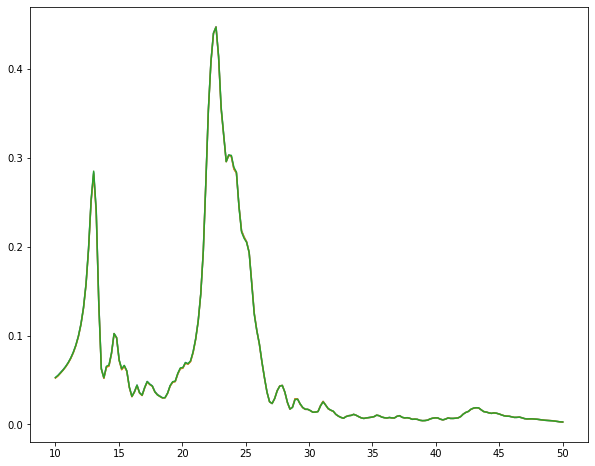

In [10]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(eng,R_trs)
plt.plot(eng,R_trs_ph0)
plt.plot(eng,R_eq)

In [13]:
dR = (R_trs-R_eq)/R_eq
dR_ph0 = (R_trs_ph0-R_eq)/R_eq

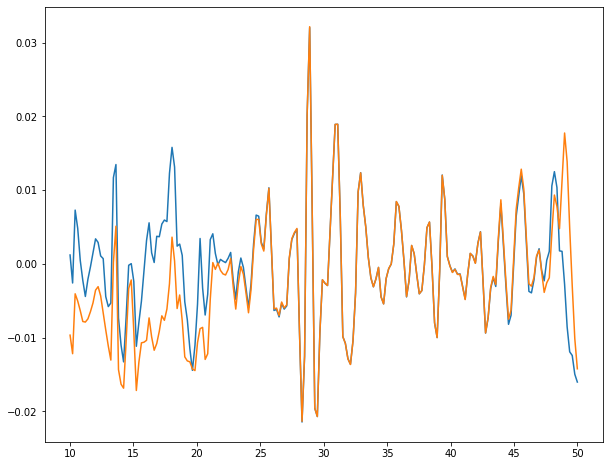

In [14]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(eng,dR)
plt.plot(eng,dR_ph0)
#plt.plot(eng_Ppmp,0.03+deps_avg)
#plt.xlim(20,55)
#plt.ylim(-0.04,0.06)

### Transient spectrum for delay 7.0

In [66]:
data_d7=P.YamboOutputParser.from_file('NoTr_E100/test/ypp/o-ypp.YPP-eps_along_E')
data_d7_ph0=P.YamboOutputParser.from_file('NoTr_E100/test/ypp-ph0/o-ypp-ph0.YPP-eps_along_E')
data_probe=P.YamboOutputParser.from_file('NoTr_E100/ypp-p-abs-damp_0.3-enrnge_10.0_50.0-timernge_0.0-50.0/o-ypp-p-abs-damp_0.3-enrnge_10.0_50.0-timernge_0.0-50.0.YPP-eps_along_E')

Parse file NoTr_E100/test/ypp/o-ypp.YPP-eps_along_E
Parse file NoTr_E100/test/ypp-ph0/o-ypp-ph0.YPP-eps_along_E
Parse file NoTr_E100/ypp-p-abs-damp_0.3-enrnge_10.0_50.0-timernge_0.0-50.0/o-ypp-p-abs-damp_0.3-enrnge_10.0_50.0-timernge_0.0-50.0.YPP-eps_along_E


In [67]:
eng = data['YPP-eps_along_E']['col1']
eps2_d7_trs = data_d7['YPP-eps_along_E']['col2']
eps1_d7_trs = data_d7['YPP-eps_along_E']['col5']
eps2_d7_trs_ph0 = data_d7_ph0['YPP-eps_along_E']['col2']
eps1_d7_trs_ph0 = data_d7_ph0['YPP-eps_along_E']['col5']
eps2_eq = data_probe['YPP-eps_along_E']['col2']
eps1_eq = data_probe['YPP-eps_along_E']['col5']

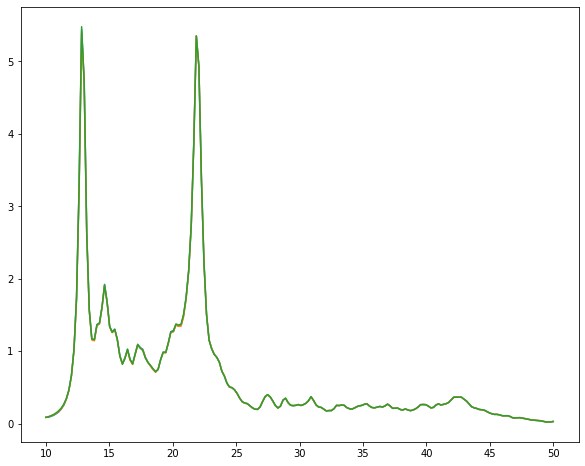

In [68]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(eng,eps2_d7_trs)
plt.plot(eng,eps2_d7_trs_ph0)
plt.plot(eng,eps2_eq)

We compute the shift of the absorption spectrum

In [69]:
deps2_d7 = (eps2_d7_trs-eps2_eq)/eps2_eq
deps2_d7_ph0 = (eps2_d7_trs_ph0-eps2_eq)/eps2_eq

(-0.04, 0.06)

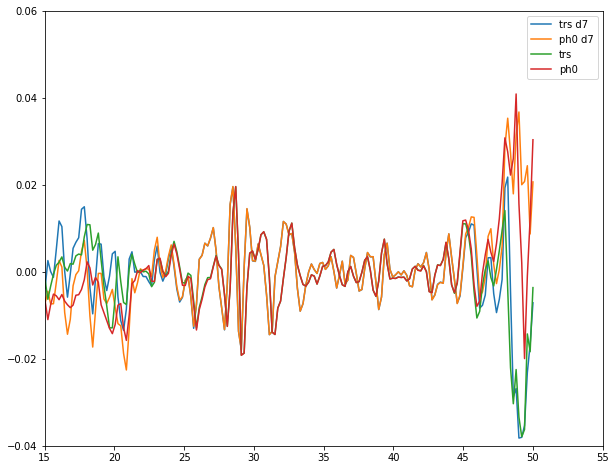

In [72]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(eng,deps2_d7,label='trs d7')
plt.plot(eng,deps2_d7_ph0,label='ph0 d7')
plt.plot(eng,deps2,label='trs')
plt.plot(eng,deps2_ph0,label='ph0')
plt.legend()
plt.xlim(15,55)
plt.ylim(-0.04,0.06)

### Transient spectrum for the 5SIGMA pump field

In [135]:
data=P.YamboOutputParser.from_file('NoTr_E100/ypp-trs-5SIGMA/o-ypp-trs-5SIGMA.YPP-eps_along_E')
data_ph0=P.YamboOutputParser.from_file('NoTr_E100/ypp-trs-5SIGMA-ph0/o-ypp-trs-5SIGMA-ph0.YPP-eps_along_E')
data_probe=P.YamboOutputParser.from_file('NoTr_E100/ypp-p-abs-damp_0.3-enrnge_10.0_50.0-timernge_0.0-50.0/o-ypp-p-abs-damp_0.3-enrnge_10.0_50.0-timernge_0.0-50.0.YPP-eps_along_E')
#data_dPint = P.YamboOutputParser.from_file('NoTr_E100/ypp-trs-abs-damp_0.3-enrnge_10.0_50.0-timernge_0.0-50.0-double_Pint/o-ypp-trs-abs-damp_0.3-enrnge_10.0_50.0-timernge_0.0-50.0-double_Pint.YPP-eps_along_E')

Parse file NoTr_E100/ypp-trs-5SIGMA/o-ypp-trs-5SIGMA.YPP-eps_along_E
Parse file NoTr_E100/ypp-trs-5SIGMA-ph0/o-ypp-trs-5SIGMA-ph0.YPP-eps_along_E
Parse file NoTr_E100/ypp-p-abs-damp_0.3-enrnge_10.0_50.0-timernge_0.0-50.0/o-ypp-p-abs-damp_0.3-enrnge_10.0_50.0-timernge_0.0-50.0.YPP-eps_along_E


In [136]:
eng = data['YPP-eps_along_E']['col1']
eps2_trs = data['YPP-eps_along_E']['col2']
eps1_trs = data['YPP-eps_along_E']['col5']
eps2_trs_ph0 = data_ph0['YPP-eps_along_E']['col2']
eps1_trs_ph0 = data_ph0['YPP-eps_along_E']['col5']
#eps2_trs_dPint = data_dPint['YPP-eps_along_E']['col2']
#eps1_trs_dPint = data_dPint['YPP-eps_along_E']['col5']
eps2_eq = data_probe['YPP-eps_along_E']['col2']
eps1_eq = data_probe['YPP-eps_along_E']['col5']

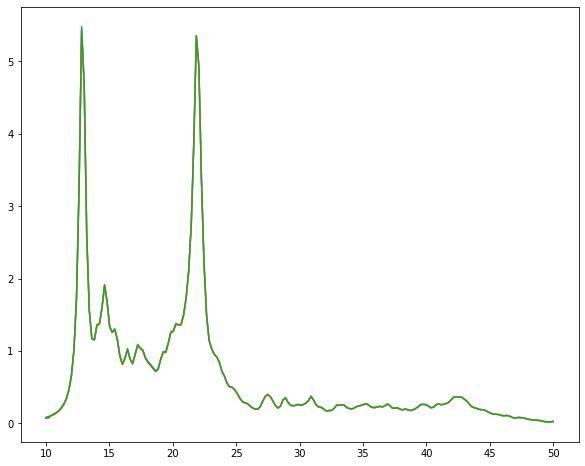

In [137]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(eng,eps2_trs)
plt.plot(eng,eps2_trs_ph0)
#plt.plot(eng,eps2_trs_dPint)
plt.plot(eng,eps2_eq)

We compute the shift of the absorption spectrum

In [63]:
deps2 = (eps2_trs-eps2_eq)/eps2_eq
#deps2_dPint = (eps2_trs_dPint-eps2_eq)/eps2_eq
deps2_ph0 = (eps2_trs_ph0-eps2_eq)/eps2_eq

(-0.04, 0.06)

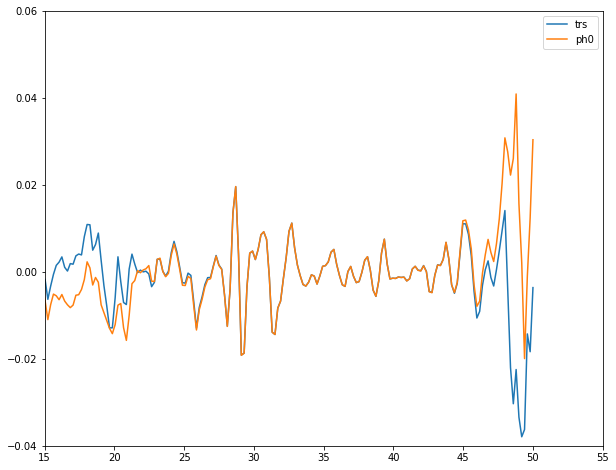

In [138]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(eng,deps2,label='trs')
#plt.plot(eng,deps2_dPint,label='double P int')
plt.plot(eng,deps2_ph0,label='ph0')
plt.legend()
plt.xlim(15,55)
plt.ylim(-0.04,0.06)

### RT analysis for the non-linear chi responses

In [3]:
# RunRules for ismhpc
# The product of ntasks_per_node*cpus_per_task is equal to 32. 
# Many mpi are needed for better performances
nodes = 1
ntasks_per_node = 32 #16
cpus_per_task = 1 #2
omp_num_threads = 1 #2
module = '/home/dalessandro/module_script/yambo_module'

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='slownodes', #'all12h',
                memory='125000',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,
                omp_num_threads=omp_num_threads,pre_processing=module)
code = C.YamboCalculator(rr,executable='yambo_nl',activate_BeeOND=True) #,reformat=False,clean_restart=False,skip=False,fatlog=True)
code.global_options()

Initialize a Yambo calculator with scheduler slurm


{'scheduler': 'slurm',
 'nodes': 1,
 'ntasks_per_node': 32,
 'cpus_per_task': 1,
 'omp_num_threads': 1,
 'gpus_per_node': None,
 'memory': '125000',
 'time': None,
 'partition': 'slownodes',
 'account': None,
 'qos': None,
 'map_by': None,
 'pe': 1,
 'rank_by': None,
 'pre_processing': '/home/dalessandro/module_script/yambo_module',
 'executable': 'yambo_nl',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'activate_BeeOND': True,
 'verbose': True,
 'fatlog': False}

In [4]:
run_dir = 'NoTr_E100/'

In [16]:
NLtime = 50 # fs
NLstep = 3 # as
#Field1_kind= "QSFIELD" # "QSFIELD PHPI90" # 
#Field2_kind= "QSFIELD 5SIGMA PHPI90"
NLBands = [1,15]

#Field1 parameters
p_eng = -0.1 # eV
NLEnRange = [15.0,50.0] # eV
NLEnSteps= 32
p_int = 1e3 # kWLm2
#p_fwhm = 0.42 # corresponds to 0.3*np.sqrt(2)
#p_width = 0.18 # fs
p_start = 9.0 # to be checked....

#Field2 parameters
P_eng = 1.56 # eV
P_int = 2.6e9 # 2*2.6e9 # kWLm2
#P_fwhm = 7.58 # corresponds to 0.3*np.sqrt(2)
#P_width = 3.22 
P_start = 0.0 # fs

inp = I.YamboInput(args='yambo_nl -u',folder=run_dir)
inp.set_array_variables(units='as',NLstep=NLstep)
inp.set_array_variables(units='fs',NLtime=NLtime,Field1_Tstart=p_start)
inp.set_array_variables(NLEnSteps=NLEnSteps,Field1_Dir=[1.,0.,0.],Field2_Dir=[1.,0.,0.])
inp.set_array_variables(units='eV',Field2_Freq=[P_eng,P_eng],Field1_Freq=[p_eng,p_eng])
inp.set_array_variables(units='eV',NLEnRange=NLEnRange)
inp.set_scalar_variables(Field1_kind='SOFTSIN',Field2_kind='SOFTSIN',Field1_pol='linear',Field2_pol='linear')
inp.set_array_variables(units='kWLm2',Field2_Int=P_int,Field1_Int=p_int)
inp.set_array_variables(NLBands=NLBands)
inp.set_scalar_variables(NL_ROLEs='w k',NL_CPU='32 1')
inp

{'args': 'yambo_nl -u',
 'folder': 'NoTr_E100/',
 'filename': 'yambo.in',
 'arguments': ['optics', 'life', 'nloptics'],
 'variables': {'DIP_Threads': [0.0, ''],
  'NL_Threads': [0.0, ''],
  'NLtime': [50, 'fs'],
  'NLLrcAlpha': [0.0, ''],
  'NLEnSteps': [32, ''],
  'NLAngSteps': [0.0, ''],
  'NLDamping': [0.2, 'eV'],
  'RADLifeTime': [-1.0, 'fs'],
  'HARRLvcs': [11017.0, 'RL'],
  'EXXRLvcs': [11017.0, 'RL'],
  'Field1_NFreqs': [1.0, ''],
  'Field1_Int': [1000.0, 'kWLm2'],
  'Field1_Width': [0.0, 'fs'],
  'Field1_Tstart': [9.0, 'fs'],
  'NLverbosity': 'high',
  'NLintegrator': 'INVINT',
  'NLCorrelation': 'IPA',
  'Field1_kind': 'SOFTSIN',
  'Field1_pol': 'linear',
  'NLBands': [[1, 15], ''],
  'NLEnRange': [[15.0, 50.0], 'eV'],
  'NLrotaxis': [[0.0, 0.0, 0.0], ''],
  'Field1_Freq': [[-0.1, -0.1], 'eV'],
  'Field1_Dir': [[1.0, 0.0, 0.0], ''],
  'NLstep': [3, 'as'],
  'Field2_Dir': [[1.0, 0.0, 0.0], ''],
  'Field2_Freq': [[1.56, 1.56], 'eV'],
  'Field2_kind': 'SOFTSIN',
  'Field2_pol': '

In [17]:
idd = 'td-nl-non-linear-chi'

jobname = [idd,'coll-par-cv_1-15B_X59RL-50B_noSM_H339RL_kpar']
results = code.run(run_dir=run_dir,input=inp,name=idd,jobname=jobname,reformat=False)

delete job_out script: NoTr_E100/job_td-nl-non-linear-chi.out
delete folder: NoTr_E100/td-nl-non-linear-chi
run command: mpirun -np 32 yambo_nl -F td-nl-non-linear-chi.in -J "td-nl-non-linear-chi,coll-par-cv_1-15B_X59RL-50B_noSM_H339RL_kpar" -C td-nl-non-linear-chi
slurm submit:  cd NoTr_E100/ ; sbatch job_td-nl-non-linear-chi.sh
computation td-nl-non-linear-chi is running...
computation td-nl-non-linear-chi ended
game_over string not found in report. Check the computation!


In [ ]:
########################################################################

In [10]:
NLtime = 50 # fs
NLstep = 3 # as
#Field1_kind= "QSFIELD" # "QSFIELD PHPI90" # 
#Field2_kind= "QSFIELD 5SIGMA PHPI90"
NLBands = [1,15]

#Field1 parameters
p_eng = -0.1 # eV
NLEnRange = [15.0,50.0] # eV
NLEnSteps= 16
p_int = 1e3 # kWLm2
#p_fwhm = 0.42 # corresponds to 0.3*np.sqrt(2)
#p_width = 0.18 # fs
p_start = 9.0 # to be checked....

#Field2 parameters
P_eng = 1.56 # eV
P_int = 2.6e9 # 2*2.6e9 # kWLm2
#P_fwhm = 7.58 # corresponds to 0.3*np.sqrt(2)
#P_width = 3.22 
P_start = 0.0 # fs

inp = I.YamboInput(folder=run_dir,filename='yambo_nl_nu.in')
inp.set_array_variables(units='eV',NLEnRange=NLEnRange)
inp.set_array_variables(NLEnSteps=NLEnSteps)
inp.set_array_variables(units='as',NLstep=NLstep)
inp.set_array_variables(units='eV',Field2_Freq=[P_eng,P_eng],Field1_Freq=[p_eng,p_eng])
inp.set_array_variables(units='fs',NLtime=NLtime,Field1_Tstart=p_start) #,Field2_FWHM=P_fwhm,Field1_FWHM=p_fwhm,
#inp.set_array_variables(units='as',NLstep=NLstep)
inp.set_array_variables(units='kWLm2',Field2_Int=P_int,Field1_Int=p_int)
inp.set_array_variables(NLBands=NLBands)
#inp.set_scalar_variables(Field1_kind=Field1_kind,Field2_kind=Field2_kind)
inp

{'args': '',
 'folder': 'NoTr_E100/',
 'filename': 'yambo_nl_nu.in',
 'arguments': ['optics', 'life', 'nloptics'],
 'variables': {'DIP_Threads': [0.0, ''],
  'NL_Threads': [0.0, ''],
  'NLtime': [50, 'fs'],
  'NLLrcAlpha': [0.0, ''],
  'NLEnSteps': [16, ''],
  'NLDamping': [0.2, 'eV'],
  'RADLifeTime': [-1.0, 'fs'],
  'HARRLvcs': [11017.0, 'RL'],
  'EXXRLvcs': [11017.0, 'RL'],
  'Field1_NFreqs': [1.0, ''],
  'Field1_Int': [1000.0, 'kWLm2'],
  'Field1_Width': [0.0, 'fs'],
  'Field1_Tstart': [9.0, 'fs'],
  'Field2_NFreqs': [1.0, ''],
  'Field2_Int': [2600000000.0, 'kWLm2'],
  'Field2_Width': [0.0, 'fs'],
  'Field2_Tstart': [0.01, 'fs'],
  'NLverbosity': 'high',
  'NLintegrator': 'INVINT',
  'NLCorrelation': 'IPA',
  'Field1_kind': 'SOFTSIN',
  'Field1_pol': 'linear',
  'Field2_kind': 'none',
  'Field2_pol': 'linear',
  'NL_CPU': '8 8',
  'NL_ROLEs': 'w k',
  'NLBands': [[1, 15], ''],
  'NLEnRange': [[15.0, 50.0], 'eV'],
  'Field1_Freq': [[-0.1, -0.1], 'eV'],
  'Field1_Dir': [[1.0, 0.0, 0

In [ ]:
idd = 'td-nl-non-linear-chi'

jobname = [idd,'coll-par-cv_1-15B_X59RL-50B_noSM_H339RL_kpar']
results = code.run(run_dir=run_dir,input=inp,name=idd,jobname=jobname,reformat=False)

delete job_out script: NoTr_E100/job_td-nl-non-linear-chi.out
delete folder: NoTr_E100/td-nl-non-linear-chi
run command: mpirun -np 64 yambo_nl -F td-nl-non-linear-chi.in -J "td-nl-non-linear-chi,coll-par-cv_1-15B_X59RL-50B_noSM_H339RL_kpar" -C td-nl-non-linear-chi
slurm submit:  cd NoTr_E100/ ; sbatch job_td-nl-non-linear-chi.sh
computation td-nl-non-linear-chi is running...
